# IAU Project - Phase 2 (Preprocessing)

Dataset: 049

Authors: **Lubomir Dlhy** (50%) & **Anastasiia Hrytsyna** (50%)

In [396]:
# Imports & Initialization
import pylab as py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import category_encoders as ce
import scipy.stats as stats
import warnings
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sklearn.feature_selection as fs
from sklearn.model_selection import train_test_split
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_palette('twilight')
pd.set_option('mode.chained_assignment', None)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Loading and merging the dataset

In [397]:
# Initialization of the data
labor_filename = "data/labor.csv"
profile_filename = "data/profiles.csv"

df_labor = pd.read_csv(labor_filename, sep='\t', index_col=0)
df_profile = pd.read_csv(profile_filename, sep='\t', index_col=0)

df_merged = pd.merge(df_labor.drop(columns=['name']), df_profile, how="inner", on='ssn')

### Data cleaning

We deleted all duplicates from the dataset as they are not relevant for the future discovery.

In [398]:
# Drop duplicates
df_merged = df_merged.drop_duplicates()

We also decided to make a few more changes to the data: 

In [399]:
# Implement the function for age calculation
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# Correct weight attribute to the positive value and round it
df_merged['weight'] = df_merged['weight'].apply(lambda x: x*(-1) if x < 0 else x)
df_merged['weight'] = df_merged['weight'].round(2)

# Correct some small grammar mistakes
df_merged['relationship'] = df_merged['relationship'].replace({'divoced':'divorced'})
df_merged['relationship'] = df_merged['relationship'].replace({'nop':'single'})
df_merged['race'] = df_merged['race'].replace({"black":"Black", 'white':"White", "blsck":"Black"})

# Fitting the info about smoking habits 
df_merged['smoker'] = df_merged['smoker'].replace({"yes":1, 'Y':1, "no":0, 'N':0})

# Modify the data types
df_merged = df_merged.astype({'indicator':'int','relationship':'category', 'blood_group': 'category','sex': 'category', 'race': 'category'})
df_merged['birthdate'] = pd.to_datetime(df_merged.birthdate)
df_merged['age'] = df_merged['birthdate'].apply(calculate_age)

### Solving missing values (NA)

In the next step we decided to examine if there are some missiing values in the dataset.

In [400]:
df_merged.isna().sum()

er-cv               29
ssn                  0
weight               0
relationship         0
alt                 29
trombocyty          29
hematokrit          29
indicator            0
ast                 29
alp                 29
leukocyty           29
erytrocyty          29
etytr               29
hemoglobin          29
hbver               29
smoker               0
birthdate            0
current_location     0
blood_group          0
name                 0
address              0
company              0
sex                  0
race                 0
age                  0
dtype: int64

There are a lot of different techniques to solve missing values. We don't implement all of them, nonetheless we decided to show their usage.

- The first one is to erase all NA values.

In [401]:
print(f"Before removing: {df_merged.shape}")
df_merged_rm = df_merged.dropna()
print(f"After removing: {df_merged_rm.shape}")

Before removing: (9816, 25)
After removing: (9503, 25)


- The second one - replacing NA values with the median value of the column.

In [402]:
# Fill na values using the median
df_merged_median = df_merged.fillna(df_merged.median(numeric_only=True))
df_merged_median.describe().loc['count':'std']

,er-cv,weight,alt,trombocyty,hematokrit,indicator,ast,alp,leukocyty,erytrocyty,etytr,hemoglobin,hbver,smoker,age
count,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000
mean,51.385201,69.801398,3.106618,6.278884,6.287525,0.642624,45.733867,56.353738,5.850299,5.832352,7.477729,6.291583,6.280674,0.404645,56.477791
std,14.358216,33.751541,3.879241,1.002329,1.000003,0.479251,12.602140,25.937560,1.614734,1.730369,0.980652,1.736564,0.986102,0.490848,33.626541


- The third one - replacing NA values by using KNN method.

In [403]:
# Fill na values using the knn
num_cols = df_merged.select_dtypes(include='number').columns
imputer = KNNImputer()
df_merged_knn = pd.DataFrame(imputer.fit_transform(df_merged[num_cols]), columns=num_cols)
df_merged_knn.describe().loc['count':'std']

,er-cv,weight,alt,trombocyty,hematokrit,indicator,ast,alp,leukocyty,erytrocyty,etytr,hemoglobin,hbver,smoker,age
count,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000
mean,51.383695,69.801398,3.108772,6.278896,6.287630,0.642624,45.734048,56.342872,5.850928,5.832487,7.477637,6.291471,6.280459,0.404645,56.477791
std,14.363356,33.751541,3.879483,1.002670,1.000238,0.479251,12.604323,25.944235,1.615246,1.731001,0.981024,1.736968,0.986375,0.490848,33.626541


- In our project we choose to replace NA values with the mean value of each column.

In [404]:
# We can fill the NA values using the fillna method or using sklearn SimpleImputer
df_merged = df_merged.fillna(df_merged.mean(numeric_only=True))
df_merged.describe().loc['count':'std']

,er-cv,weight,alt,trombocyty,hematokrit,indicator,ast,alp,leukocyty,erytrocyty,etytr,hemoglobin,hbver,smoker,age
count,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000
mean,51.385495,69.801398,3.109175,6.278904,6.287477,0.642624,45.733826,56.338496,5.850812,5.832602,7.477704,6.291585,6.280711,0.404645,56.477791
std,14.358215,33.751541,3.878957,1.002329,1.000003,0.479251,12.602140,25.936049,1.614707,1.730362,0.980652,1.736564,0.986102,0.490848,33.626541


In [405]:
num_cols = df_merged.select_dtypes(include='number').columns
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_merged_mean_imputer = pd.DataFrame(imp_mean.fit_transform(df_merged[num_cols]), columns=num_cols)
df_merged_mean_imputer.describe().loc['count':'std']

,er-cv,weight,alt,trombocyty,hematokrit,indicator,ast,alp,leukocyty,erytrocyty,etytr,hemoglobin,hbver,smoker,age
count,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000,9816.000000
mean,51.385495,69.801398,3.109175,6.278904,6.287477,0.642624,45.733826,56.338496,5.850812,5.832602,7.477704,6.291585,6.280711,0.404645,56.477791
std,14.358215,33.751541,3.878957,1.002329,1.000003,0.479251,12.602140,25.936049,1.614707,1.730362,0.980652,1.736564,0.986102,0.490848,33.626541


### Deleting all useless information

In [406]:
df_merged.dtypes

er-cv                      float64
ssn                         object
weight                     float64
relationship              category
alt                        float64
trombocyty                 float64
hematokrit                 float64
indicator                    int32
ast                        float64
alp                        float64
leukocyty                  float64
erytrocyty                 float64
etytr                      float64
hemoglobin                 float64
hbver                      float64
smoker                       int64
birthdate           datetime64[ns]
current_location            object
blood_group               category
name                        object
address                     object
company                     object
sex                       category
race                      category
age                          int64
dtype: object

We also decided to erase all worthless for machine learning string columns.

In [407]:
cols_string = df_merged.select_dtypes(include=['object','datetime']).columns
df_merged = df_merged.drop(columns=cols_string)
df_merged.columns

Index(['er-cv', 'weight', 'relationship', 'alt', 'trombocyty', 'hematokrit',
       'indicator', 'ast', 'alp', 'leukocyty', 'erytrocyty', 'etytr',
       'hemoglobin', 'hbver', 'smoker', 'blood_group', 'sex', 'race', 'age'],
      dtype='object')

...and make the deep copy of the whole dataset.

In [408]:
df_merged_enc = df_merged.copy(deep = True)

### Data encoding

We also changed categorical values to the numeric ones and some of them devided into different columns.

In [409]:
binary_cols = ['sex','smoker']
ce_ordinal = ce.BinaryEncoder(cols=binary_cols)
ce_ordinal.fit_transform(df_merged_enc).rename(columns={'smoker_0':'smoker_no','smoker_1':'smoker_yes','sex_0':'sex_F','sex_1':'sex_M'})

,er-cv,weight,relationship,alt,trombocyty,hematokrit,indicator,ast,alp,leukocyty,...,etytr,hemoglobin,hbver,smoker_no,smoker_yes,blood_group,sex_F,sex_M,race,age
0,78.56699,15.76,divorced,1.65351,5.63528,8.01736,0,65.02434,47.76901,7.836280,...,6.99561,4.79938,6.495990,0,1,A+,0,1,White,97
1,68.31516,61.36,single,1.94992,5.75525,6.44427,1,20.92051,56.43231,6.612620,...,7.00566,4.93635,6.280711,1,0,A+,0,1,White,97
2,33.51458,82.07,divorced,2.04132,5.11614,6.00166,1,42.74233,87.57738,5.078470,...,7.24444,6.39873,4.772550,1,0,A+,0,1,White,97
3,74.30939,29.68,married,4.24185,6.44273,5.30115,1,33.94714,83.31624,5.662260,...,6.98433,6.17203,5.510310,0,1,B+,1,0,Black,57
4,50.01224,66.13,single,2.30110,5.20337,5.09042,0,31.30351,77.41349,4.603190,...,8.28462,5.94849,6.943080,0,1,B+,1,0,Black,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,51.52408,57.91,married,4.12008,8.04632,5.32922,1,62.01858,60.63787,4.080450,...,8.69608,7.59272,4.082660,0,1,AB-,1,0,Asian,46
9910,56.44960,61.76,single,3.33216,7.13134,6.15255,0,61.73561,69.25641,6.835230,...,8.55201,7.09931,6.151090,0,1,AB-,1,0,Asian,46
9911,56.94538,80.45,married,7.40929,5.10015,5.89867,1,25.15416,50.51565,7.101610,...,7.08184,7.69433,5.633070,1,0,O-,1,0,White,111
9912,50.37612,51.94,divorced,2.03290,5.07519,6.45276,0,31.50216,85.42666,5.850812,...,7.40929,6.49957,6.409050,1,0,O-,1,0,White,111


In [410]:
ordinal_cols = ['blood_group','race','relationship','sex']
ce_ordinal = ce.OrdinalEncoder(cols=ordinal_cols)
df_merged_enc = ce_ordinal.fit_transform(df_merged_enc)
df_merged_enc

,er-cv,weight,relationship,alt,trombocyty,hematokrit,indicator,ast,alp,leukocyty,erytrocyty,etytr,hemoglobin,hbver,smoker,blood_group,sex,race,age
0,78.56699,15.76,1,1.65351,5.63528,8.01736,0,65.02434,47.76901,7.836280,4.86947,6.99561,4.79938,6.495990,1,1,1,1,97
1,68.31516,61.36,2,1.94992,5.75525,6.44427,1,20.92051,56.43231,6.612620,5.94553,7.00566,4.93635,6.280711,0,1,1,1,97
2,33.51458,82.07,1,2.04132,5.11614,6.00166,1,42.74233,87.57738,5.078470,3.70493,7.24444,6.39873,4.772550,0,1,1,1,97
3,74.30939,29.68,3,4.24185,6.44273,5.30115,1,33.94714,83.31624,5.662260,7.57419,6.98433,6.17203,5.510310,1,2,2,2,57
4,50.01224,66.13,2,2.30110,5.20337,5.09042,0,31.30351,77.41349,4.603190,4.19887,8.28462,5.94849,6.943080,1,2,2,2,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,51.52408,57.91,3,4.12008,8.04632,5.32922,1,62.01858,60.63787,4.080450,7.87961,8.69608,7.59272,4.082660,1,5,2,4,46
9910,56.44960,61.76,2,3.33216,7.13134,6.15255,0,61.73561,69.25641,6.835230,7.11356,8.55201,7.09931,6.151090,1,5,2,4,46
9911,56.94538,80.45,3,7.40929,5.10015,5.89867,1,25.15416,50.51565,7.101610,8.71152,7.08184,7.69433,5.633070,0,8,2,1,111
9912,50.37612,51.94,1,2.03290,5.07519,6.45276,0,31.50216,85.42666,5.850812,2.87124,7.40929,6.49957,6.409050,0,8,2,1,111


In [411]:
df_merged_enc.dtypes

er-cv           float64
weight          float64
relationship      int32
alt             float64
trombocyty      float64
hematokrit      float64
indicator         int32
ast             float64
alp             float64
leukocyty       float64
erytrocyty      float64
etytr           float64
hemoglobin      float64
hbver           float64
smoker            int64
blood_group       int32
sex               int32
race              int32
age               int64
dtype: object

### Outliers detection

Furthermore we implemented two methods for the outlier's detection.

In [412]:
def outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[(df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))]

def outliers_std(df):
    data_mean, data_std = df.mean(), df.std()
    lower, upper = data_mean - data_std * 3, data_mean + data_std * 3 
    return df[(df < lower) | (df > upper)]

All columns were checked for the outliers...

array([[<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'relationship'}>,
        <AxesSubplot:title={'center':'alt'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'hematokrit'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'ast'}>],
       [<AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>,
        <AxesSubplot:title={'center':'etytr'}>],
       [<AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'blood_group'}>],
       [<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

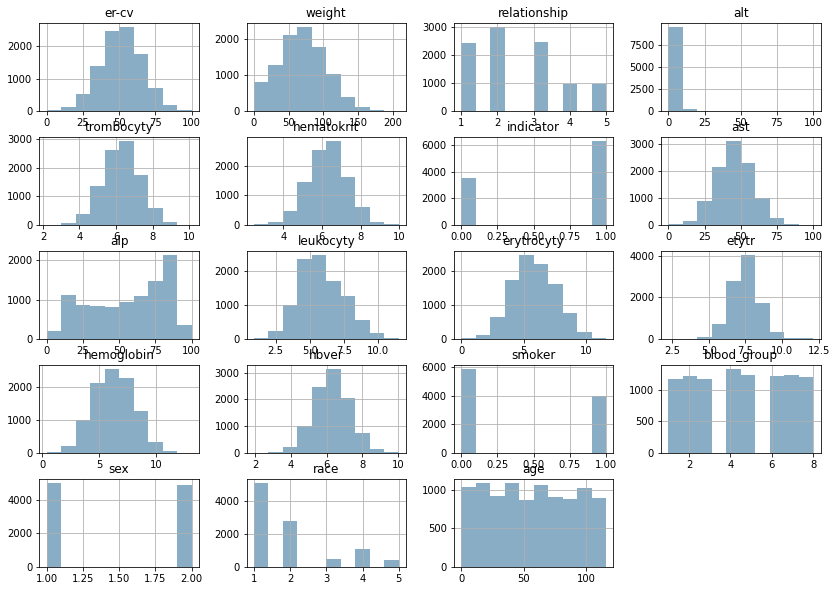

In [413]:
df_merged_enc.hist(figsize=(14,10))

In [414]:
out_iqr = outliers_iqr(df_merged_enc)
outliers_iqr_count = out_iqr.count()

out_std = outliers_std(df_merged_enc)
outliers_std_count = out_std.count()

print("Outliers using IQR method:")
print(outliers_iqr_count)
print("\nOutliers using standard deviation method:")
print(outliers_std_count)

Outliers using IQR method:
er-cv             82
weight            41
relationship     979
alt             1037
trombocyty        62
hematokrit        73
indicator          0
ast               63
alp                0
leukocyty         28
erytrocyty        27
etytr            201
hemoglobin        14
hbver             73
smoker             0
blood_group        0
sex                0
race            1498
age                0
dtype: int64

Outliers using standard deviation method:
er-cv            29
weight           22
relationship      0
alt             141
trombocyty       14
hematokrit       34
indicator         0
ast              29
alp               0
leukocyty        15
erytrocyty       13
etytr            76
hemoglobin        6
hbver            27
smoker            0
blood_group       0
sex               0
race              0
age               0
dtype: int64


We decided to remove all outliers in columns, where there are not too many of them (due to iqr method), as they do not have a huge impact on the final outcome.

In [415]:
# Remove outliers in those attributes with less than 100 outliers
print(">> Before removing")
print(df_merged_enc.shape)
out_iqr_0_100 = outliers_iqr_count[(outliers_iqr_count > 0) & (outliers_iqr_count < 100)]
df_merged_enc = df_merged_enc.drop(out_iqr[out_iqr_0_100.index.tolist()].dropna(how='all').index)
print(">> After removing")
print(df_merged_enc.shape)

>> Before removing
(9816, 19)
>> After removing
(9372, 19)


Other columns contain a lot of outliers and we can't just delete them. In such columns, which are not categorical and contains many outliers (alt & etytr for example), we have replaced them with an average values, 10% or 90% quantiles (to get more significant modification of them).

In [416]:
def replace_outliers_10_90(df, cols):
    for col in cols: 
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers_lower = df[col][ df[col]<lower ]
        outliers_upper = df[col][ df[col]>upper ]
        
        p95 = df[col].quantile(0.90)
        p5 = df[col].quantile(0.10)
        for idx in outliers_lower.index:
            df[col][idx] = p5
        for idx in outliers_upper.index:
            df[col][idx] = p95       
    return df

In [417]:
def replace_outliers_average(df, cols):
    for col in cols: 
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outliers_lower = df[col][ df[col]<lower ]
        outliers_upper = df[col][ df[col]>upper ]
        
        p50 = df[col].quantile(0.50)
        for idx in outliers_lower.index:
            df[col][idx] = p50
        for idx in outliers_upper.index:
            df[col][idx] = p50        
    return df

- Blue - before replacing outliers with an average value
- Purple - after replacing outliers with an average value

<AxesSubplot:>

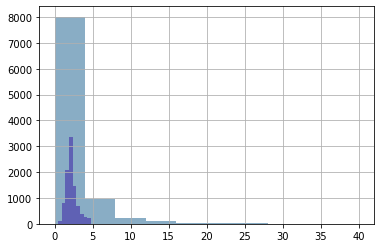

In [418]:
df_merged_enc['alt'].hist()
df_merged_enc = replace_outliers_average(df_merged_enc, ['alt'])
df_merged_enc['alt'].hist()

- Blue - before replacing outliers with the 10% or 90% quantiles
- Purple - after replacing outliers with the 10% or 90% quantiles

<AxesSubplot:>

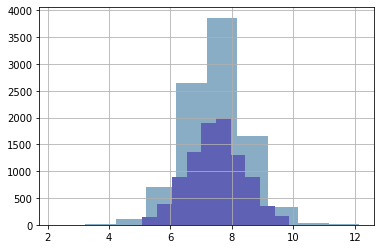

In [419]:
df_merged_enc['etytr'].hist()
df_merged_enc = replace_outliers_10_90(df_merged_enc, ['etytr'])
df_merged_enc['etytr'].hist()

### Data transformation

First of all we divided our dataset into train and test sets.

In [420]:
# 80% train and 20% test
df_train, df_test = train_test_split(df_merged_enc, test_size = 0.2 , random_state=22)
print(df_train.shape, df_test.shape)

(7497, 19) (1875, 19)


Afterwards we implemented a few methods for scaling and normalizing train data.
ColumnTransformer & PowerTransformer was used to change the distribution of 'alt' column, which was skewed and had plenty of outliers (more than 900).
We used StandardScaler to scale data to the interval (0,1), which was necessary in order to work with some classification algorithms.
In addition, we also used Normalizer to center data (turn mean into 0), which was used to make the distribution of data more gaussian-like.

In [421]:
transformer_step = ColumnTransformer(remainder='passthrough', transformers=[('alt', PowerTransformer(), ['alt'])])

pipe = Pipeline([
    ('alt', transformer_step),
    ('scaler',StandardScaler()),
    ('normalizer',Normalizer())
])

cols = list(dict.fromkeys(['alt']+df_train.columns.tolist()))
df_train_after = pd.DataFrame(pipe.fit_transform(df_train), columns=cols)

- The data before and after transforming:

<AxesSubplot:ylabel='Density'>

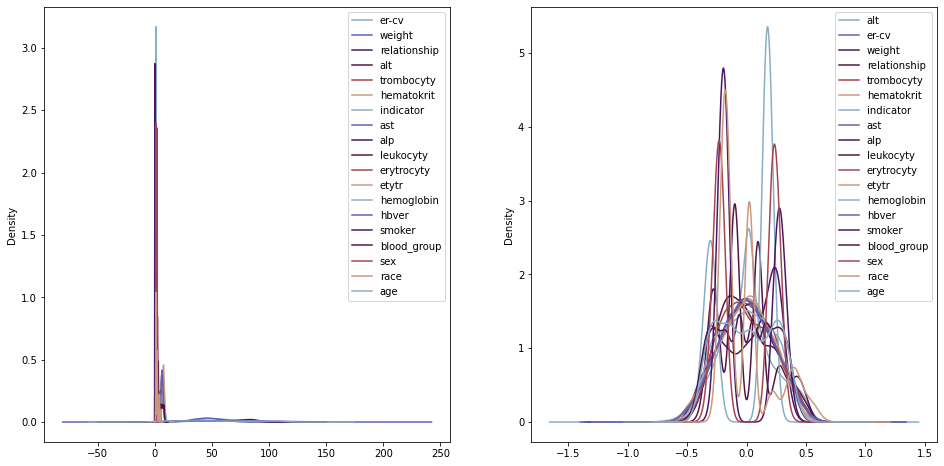

In [422]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16,8)
df_train.plot.kde(ax=ax1)
df_train_after.plot.kde(ax=ax2)

array([[<AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'relationship'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'hematokrit'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'ast'}>],
       [<AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>,
        <AxesSubplot:title={'center':'etytr'}>],
       [<AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'blood_group'}>],
       [<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

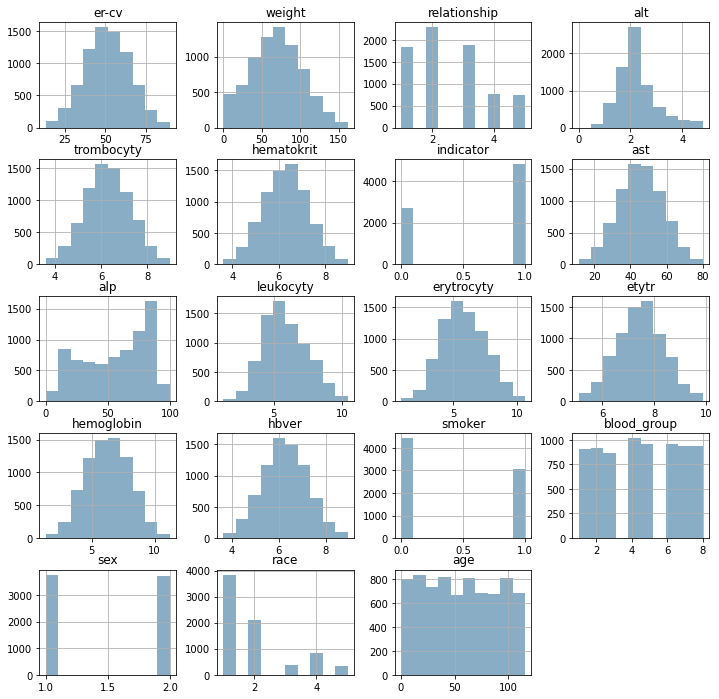

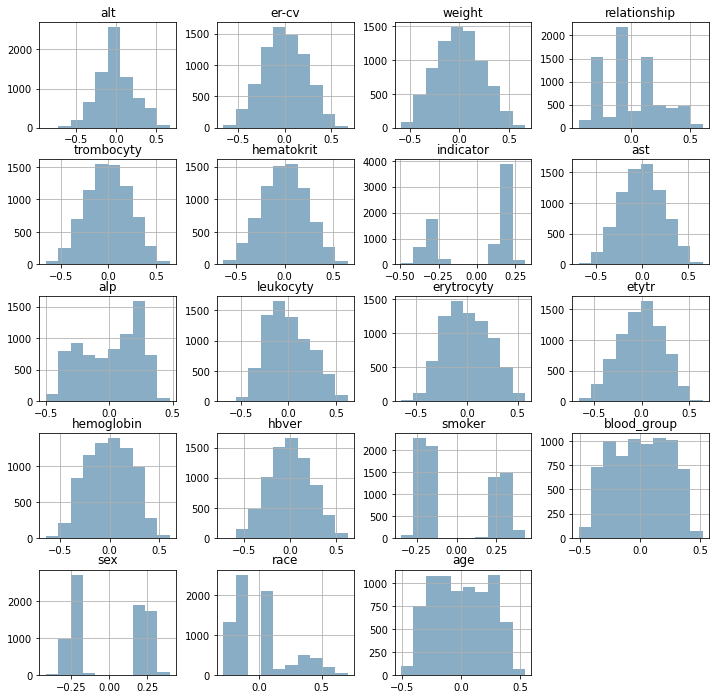

In [423]:
df_train.hist(figsize=(12,12))
df_train_after.hist(figsize=(12,12))

### Feature selection

Firstly, we tried to identify the variables with the low variance (less than 20%). All of the attributes (19) passed our test.

In [424]:
print('Before testing:')
print(df_train.shape)

varth = fs.VarianceThreshold(threshold=(0.2))
varth_data = varth.fit_transform(df_train)
print('\nAfter testing:')
print(pd.DataFrame(varth_data,columns=df_train.columns[varth.get_support()]).shape)

Before testing:
(7497, 19)

After testing:
(7497, 19)


Later, we used two evaluation techniques to analyze which attributes are important to target variable (indicator):
- f_classif (ANOVA)
- mutual_info_classif (kNN)

In [425]:
f_scores = fs.f_classif(df_train, df_train['indicator'])
pd.DataFrame(f_scores,columns= df_train.columns).loc[0,:].sort_values(ascending=False)

indicator              inf
leukocyty       908.428995
erytrocyty      827.912218
alt             279.887629
alp               9.629779
etytr             2.035314
er-cv             1.075530
relationship      1.032422
weight            0.779663
hematokrit        0.686650
smoker            0.600169
sex               0.522702
trombocyty        0.448406
blood_group       0.396240
race              0.338389
hbver             0.283062
ast               0.261130
age               0.127540
hemoglobin        0.003232
Name: 0, dtype: float64

In [426]:
f_scores = fs.mutual_info_classif(df_train, df_train['indicator'])
pd.DataFrame(f_scores, columns=['Mutual information'], index=df_train.columns).sort_values('Mutual information',ascending=False)

,Mutual information
indicator,0.654148
leukocyty,0.073973
erytrocyty,0.061371
alt,0.046992
etytr,0.034428
trombocyty,0.009736
sex,0.009000
age,0.007835
smoker,0.007549
ast,0.006435


Both techniques produce similar outcome:
1. leukocyty
2. erytrocyty
3. alt

All of these attributes have dominant correlation with the main variable compared to another variables (which actually confirm that they have a huge impact on the disease). Thereafter, we decided to keep such sequence as was shown in the first method.

To summarize, we also selected a few (5) best features that are shown in the table.

In [427]:
selector = fs.SelectKBest(fs.f_classif, k=5)
f_scores = selector.fit_transform(df_train,df_train['indicator'])
cols = selector.get_support()
pd.DataFrame(f_scores,columns= df_train.columns[cols])

,alt,indicator,alp,leukocyty,erytrocyty
0,2.32198,0.0,82.13492,5.83210,5.44470
1,1.62343,1.0,84.50490,4.43892,6.17181
2,2.22291,1.0,31.74145,6.68693,5.22608
3,2.18099,1.0,89.04988,5.40670,6.24684
4,2.08059,1.0,82.28479,9.61492,3.36856
...,...,...,...,...,...
7492,2.84399,1.0,80.55867,4.47752,6.89202
7493,1.39103,0.0,33.84369,3.79178,3.97144
7494,2.05530,1.0,3.10079,6.60665,5.28606
7495,1.88631,1.0,84.14213,4.60311,6.21728
